In [2]:
import os
from pynq import Overlay
from pynq import allocate
import xrfclk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from axififo import AxiStreamFifoDriver
import scipy.signal
import scipy.io
import time
import serial

In [3]:
ol = Overlay("hw/top_20240110_155705.bit", download=True)
xrfclk.set_ref_clks(lmk_freq=122.88, lmx_freq=409.6)

In [6]:
dac_fsamp = 6.144e9 #Hz
dds_phase_bits = 32
scale_bits = 18
scale_frac_bits = 16

awg_dma = ol.axi_dma_0.sendchannel
adc_dma = ol.axi_dma_0.recvchannel
# 8x2048-deep data buffer (256b/word)
# 8x512-deep timestamp buffer (64b/word)
# information:
# 8x2x(64+256)
# 8 channels, which report both timestamp and data channel ID and sample count (conservative estimate of 16 bytes for each)
adc_buffer = allocate(shape=((8*2048*256+8*512*64+8*2*(256+64))//16,), dtype=np.uint16)
# 8x32-deep data buffer (256b/word)
awg_buffer = allocate(shape=((8*32*256)//16,), dtype=np.uint16)

def receive_adc_data():
    adc_dma.transfer(adc_buffer)
    
def send_awg_data():
    awg_dma.transfer(awg_buffer)

def packetize(long_word, num_words):
    packet = []
    print(f'packetizing word {long_word:#0{num_words*8}x} into {num_words} words')
    for word in range(num_words):
        packet.append(long_word & ((1 << 32) - 1))
        long_word >>= 32
    return packet
    
def set_dac_scale(scales):
    scale_word = 0
    for channel in range(8):
        # scale is 2Q16, so quantize appropriately
        quant = int(scales[channel] * 2**scale_frac_bits)
        if (quant >> scale_frac_bits) > 1 or (quant >> scale_frac_bits) < -2:
            raise ValueError(f'cannot quantize {scale} to {scale_bits-scale_frac_bits}Q{scale_frac_bits}')
        if quant < 0:
            quant += 2**scale_bits
        scale_word |= quant << (scale_bits * channel)
        #print(f'channel = {channel}:')
        #print(f'got scale = {scales[channel]}')
        #print(f'scale -> scale_2Q16: {quant} ({quant:#010x})')
    ol.dac_scale_config.fifo.send_tx_pkt(packetize(scale_word, (int(np.ceil(scale_bits/4))*4 * 8) // 32))

def set_dds_freq(freqs_hz):
    pinc_word = 0
    for channel in range(8):
        pinc = int((freqs_hz[channel]/dac_fsamp)*(2**dds_phase_bits))
        pinc_word |= pinc << (dds_phase_bits * channel)
        #print(f'channel = {channel}:')
        #print(f'got freq_hz = {freqs_hz[channel]/1e6}MHz')
        #print(f'freq_hz -> phase_inc: {pinc} ({pinc:#010x})')
    ol.dds_phase_inc.fifo.send_tx_pkt(packetize(pinc, (dds_phase_bits * 8) // 32))
    time.sleep(0.008)
    
def set_awg_triggers(trigger_modes):
    trigger_word = 0
    for channel in range(8):
        if trigger_modes[channel] not in range(0,3):
            raise ValueError(f'invalid selection for trigger mode ({trigger_modes[channel]}) on channel ({channel})')
        trigger_word |= trigger_modes[channel] << (2*channel)
    ol.awg_trigger_out_config.fifo.send_tx_pkt([trigger_word])
    time.sleep(0.008)
    
def set_awg_burst_length(burst_lengths):
    packet = []
    for channel in range(8):
        packet.append(burst_lengths[channel] & ((1 << 32) - 1))
        packet.append((burst_lengths[channel] >> 32) & ((1 << 32) - 1))
    ol.awg_burst_length.fifo.send_tx_pkt(packet)
    time.sleep(0.008)
    
def set_awg_frame_depth(depths):
    frame_depth_word = 0
    for channel in range(8):
        if depths[channel] not in range(0, 2049):
            raise ValueError(f'invalid frame depth ({depths[channel]}) for channel ({channel})')
        frame_depth_word |= depths[channel] << (12*channel)
    print(f'{frame_depth_word:#024x}')
    ol.awg_frame_depth.fifo.send_tx_pkt(packetize(frame_depth_word, (12*8)//32))
    time.sleep(0.008)

def start_awg():
    ol.awg_start_stop.fifo.send_tx_pkt([2])
    time.sleep(0.008)
    
def stop_awg():
    ol.awg_start_stop.fifo.send_tx_pkt([1])
    time.sleep(0.008)
    
def set_all_dds():
    ol.dac_mux_config.fifo.send_tx_pkt([0xfedcba98])
    time.sleep(0.008)
    
def set_all_awg():
    ol.dac_mux_config.fifo.send_tx_pkt([0x76543210])
    time.sleep(0.008)

In [17]:
# send data with AWG
# DMA buffer is allocated at 8x64x256b, so set frame length of 64
stop_awg() # stop the AWG to make sure we return to DMA_IDLE state
# first set the trigger output (not really necessary now)
set_awg_triggers([0]*8)
# now set burst lengths
set_awg_burst_length([1]*8) # run for 2^64 - 1 cycles, basically forever
# set dac scale and set mux to use AWG
set_dac_scale([1] + [0]*7) # only use first AWG channel
set_all_awg() # set mux to select AWGs
# generate waveform
t = np.linspace(0,1,32*16)
for i in range(8):
    awg_buffer[i*32*16:(i+1)*32*16] = (2**14-1)*scipy.signal.sawtooth(20*np.pi*t,width=0.5)
    #if i % 2 == 0:
    #    awg_buffer[i*64*16:(i+1)*64*16] = (2**15-1)*scipy.signal.chirp(t,f0=1,f1=250,t1=1,method='linear')
    #else:
    #    awg_buffer[i*64*16:(i+1)*64*16] = (2**15-1)*scipy.signal.chirp(t,f0=250,f1=1,t1=1,method='linear')
# set frame depth and do DMA
set_awg_frame_depth([32]*8)
send_awg_data()
print(ol.awg_dma_error.fifo.get_rx_fifo_pkt())
start_awg()

packetizing word 0x00000000000000000000000000000000010000 into 5 words
0x20020020020020020020020
packetizing word 0x20020020020020020020020 into 3 words
[]


In [18]:
print(ol.buffer_timestamp_width.fifo.get_rx_fifo_pkt())
print(ol.awg_dma_error.fifo.get_rx_fifo_pkt())

[]
[]


In [14]:
stop_awg()

In [83]:
set_dac_scale([0.25] + [0]*7)

packetizing word 0x00000000000000000000000000000000004000 into 5 words


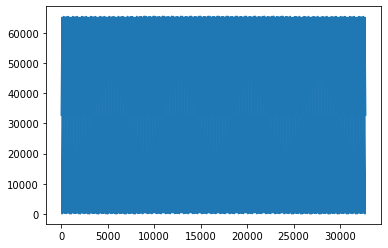

In [78]:
plt.plot(awg_buffer[0:2048*16])

In [12]:
# send data with DDS
set_all_dds()
set_dds_freq([100e6]*8)
set_dac_scale([1]*8)

channel = 0:
got freq_hz = 100.0MHz
freq_hz -> phase_inc: 69905066 (0x042aaaaa)
channel = 1:
got freq_hz = 100.0MHz
freq_hz -> phase_inc: 69905066 (0x042aaaaa)
channel = 2:
got freq_hz = 100.0MHz
freq_hz -> phase_inc: 69905066 (0x042aaaaa)
channel = 3:
got freq_hz = 100.0MHz
freq_hz -> phase_inc: 69905066 (0x042aaaaa)
channel = 4:
got freq_hz = 100.0MHz
freq_hz -> phase_inc: 69905066 (0x042aaaaa)
channel = 5:
got freq_hz = 100.0MHz
freq_hz -> phase_inc: 69905066 (0x042aaaaa)
channel = 6:
got freq_hz = 100.0MHz
freq_hz -> phase_inc: 69905066 (0x042aaaaa)
channel = 7:
got freq_hz = 100.0MHz
freq_hz -> phase_inc: 69905066 (0x042aaaaa)
channel = 0:
got scale = 1
scale -> scale_2Q16: 65536 (0x00010000)
channel = 1:
got scale = 1
scale -> scale_2Q16: 65536 (0x00010000)
channel = 2:
got scale = 1
scale -> scale_2Q16: 65536 (0x00010000)
channel = 3:
got scale = 1
scale -> scale_2Q16: 65536 (0x00010000)
channel = 4:
got scale = 1
scale -> scale_2Q16: 65536 (0x00010000)
channel = 5:
got scale = 

OverflowError: int too big to convert

In [17]:
ol.awg_dma_error.fifo.read_num_rx_words()

0

In [3]:
ol?

Type:            Overlay
String form:     <pynq.overlay.Overlay object at 0xffff8c52e170>
File:            /usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/overlay.py
Docstring:      
Default documentation for overlay hw/top.bit. The following
attributes are available on this overlay:

IP Blocks
----------
axi_dma_0            : pynq.lib.dma.DMA
usp_rf_data_converter_0 : pynq.overlay.DefaultIP
sample_discriminator_config/fifo : axififo.AxiStreamFifoDriver
buffer_config/fifo   : axififo.AxiStreamFifoDriver
adc_mux_config/fifo  : axififo.AxiStreamFifoDriver
buffer_start_stop/fifo : axififo.AxiStreamFifoDriver
awg_frame_depth/fifo : axififo.AxiStreamFifoDriver
awg_burst_length/fifo : axififo.AxiStreamFifoDriver
awg_start_stop/fifo  : axififo.AxiStreamFifoDriver
awg_trigger_out_config/fifo : axififo.AxiStreamFifoDriver
dac_mux_config/fifo  : axififo.AxiStreamFifoDriver
trigger_manager_config/fifo : axififo.AxiStreamFifoDriver
dac_scale_config/fifo : axififo.AxiStreamFifoDriver
